# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# Pre-Processing

In [2]:
# Load and combine data
PATH_TO_FILE = "../raw data/aapl_2016_2020.csv"
df = pd.read_csv(PATH_TO_FILE, low_memory=False)
df.columns = df.columns.str.strip()

# Option type
option_type = "put"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# For call options, use the call columns; we want to predict best_bid ([C_BID]) and best_offer ([C_ASK]).
option_type = "call"
if option_type == "call":
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', 
                    '[C_VEGA]', '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
else:
    # For put options, you would adapt accordingly.
    pass

# Drop rows with missing data in the essential columns
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[C_BID]', '[C_ASK]']
df.dropna(subset=essential_cols, inplace=True)

# Prepare a DataFrame for call options
if option_type == "call":
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'best_bid', 'best_offer']
    model_file = 'mlp1_call_model.h5'
else:
    # For put options, adjust accordingly.
    pass

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

# Save the processed option data to CSV, uncomment if needed
# option_df.to_csv(output_file, index=False)

# Hyperparameters

In [3]:
# Hyperparameters
n_units_per_layer = [256, 128, 32, 2]
layers = 4
n_batch = 1024
n_epochs = 25

# Building model

In [4]:
feature_cols = ['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 
                'vega', 'theta', 'rho', 'time_to_expiry']
target_cols = ['best_bid', 'best_offer']

X = option_df[feature_cols]
y = option_df[target_cols]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model 
model = Sequential()

# Scale data remains unchanged
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without activation and then apply LeakyReLU
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i], activation='relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1], activation='relu'))

# Learning rate scheduling remains unchanged
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,650 (154.88 KB)

 Trainable params: 39,650 (154.88 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [5]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback])

predictions = model.predict(X_test_scaled)
equilibrium_mse = np.mean(np.square(np.mean(y_test.values, axis=1) - np.mean(predictions, axis=1)))
spread_mse = np.mean(np.square(np.diff(y_test.values, axis=1) - np.diff(predictions, axis=1)))
print("Evaluation Metrics:")
print("Equilibrium MSE:", equilibrium_mse)
print("Spread MSE:", spread_mse)

# Save the model
model.save(model_file)

Epoch 1/25
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1175.2555 - mae: 13.9264 - val_loss: 1.6720 - val_mae: 0.7648 - learning_rate: 0.0010
Epoch 2/25
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4146 - mae: 0.6850 - val_loss: 0.9938 - val_mae: 0.5538 - learning_rate: 0.0010
Epoch 3/25
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8885 - mae: 0.5291 - val_loss: 0.6808 - val_mae: 0.4612 - learning_rate: 0.0010
Epoch 4/25
626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6656 - mae: 0.4594 - val_loss: 0.5401 - val_mae: 0.4244 - learning_rate: 0.0010
Epoch 5/25
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5723 - mae: 0.4268 - val_loss: 0.6051 - val_mae: 0.4513 - learning_rate: 0.0010
Epoch 6/25
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0931 - mae: 0.4722 - val_loss: 0.4917 - val_mae: 0.4040 - learning_rate: 0.0010
Epoch 7/25
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4443 - mae: 0.3852 - val_loss: 0.3848 - val_mae: 0.3639 - learning_rate: 0.0010
Ep

Evaluation Metrics:
Equilibrium MSE: 0.14118331111544208
Spread MSE: 0.45977515054262685


# Plot the loss

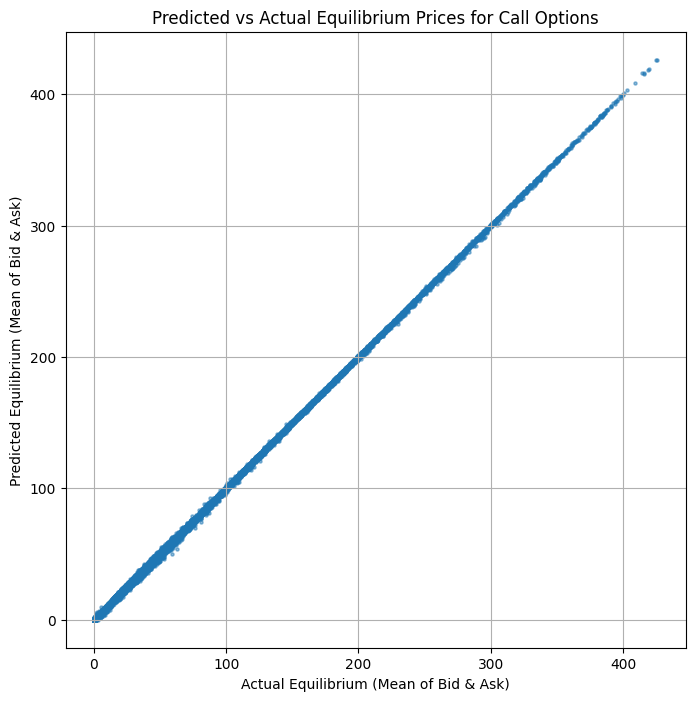

In [6]:
# Cell 8: Optional - Plot Predicted vs Actual Equilibrium Values
plt.figure(figsize=(8, 8))
plt.scatter(np.mean(y_test.values, axis=1), np.mean(predictions, axis=1), s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium (Mean of Bid & Ask)')
plt.ylabel('Predicted Equilibrium (Mean of Bid & Ask)')
plt.title('Predicted vs Actual Equilibrium Prices for Call Options')
plt.grid(True)
plt.show()

# Test random entries

In [7]:
loaded_model = load_model(model_file)

# Select a random sample of 10 entries
sample_entries = X.sample(10)
sample_indices = sample_entries.index

# Scale the sample entries and generate predictions
sample_scaled = scaler.transform(sample_entries)
sample_preds = loaded_model.predict(sample_scaled)

# Build a DataFrame to compare actual vs. predicted values
results_df = pd.DataFrame({
    'Actual Best Bid': y.loc[sample_indices, 'best_bid'].values,
    'Predicted Best Bid': sample_preds[:, 0],
    'Actual Best Offer': y.loc[sample_indices, 'best_offer'].values,
    'Predicted Best Offer': sample_preds[:, 1]
}, index=sample_indices)

print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
        Actual Best Bid  Predicted Best Bid  Actual Best Offer  \
213272            10.76           10.759849              10.90   
354601             0.00            0.000000               0.08   
2524              32.56           32.269974              33.35   
743879             5.41            5.034170               5.45   
614338            10.65           11.122408              10.80   
786854            54.10           54.058224              54.85   
737230             7.40            7.689769               7.55   
210507           183.25          183.223587             184.09   
956652            71.50           70.231491              72.25   
222561             1.98            1.750064               1.99   

        Predicted Best Offer  
213272             10.703626  
354601              0.000000  
2524               33.037983  
743879              4.910356  
614338             11.070444  
786854             55.060299  
737230            